## Pyspark Code {#pysparkcode}

In [ ]:
!pip install pyspark
!pip install pandas

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd

In [24]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Android Malware Detection") \
    .getOrCreate()

In [25]:
# Load CSV file into DataFrame
data = spark.read.csv('./Android_Malware_Data.csv', header=True, inferSchema=True)

In [26]:
# Remove leading spaces from column names
for column_name in data.columns:
    new_column_name = column_name.strip()  # Remove leading and trailing spaces
    data = data.withColumnRenamed(column_name, new_column_name)

In [27]:
data = data.withColumnRenamed('Fwd Header Length.1', 'Fwd Header Length_1')

In [28]:
# Drop rows with missing values
data = data.dropna()

In [29]:
# Data preprocessing
feature_columns = [col_name for col_name in data.columns if col_name not in ['Flow ID','Label','Source IP','Destination IP','Timestamp','CWE Flag Count','Down/Up Ratio','Fwd Avg Bytes/Bulk']]

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(data)

In [30]:

# Label indexing (converting labels to numerical values)
from pyspark.ml.feature import StringIndexer
label_indexer = StringIndexer(inputCol='Label', outputCol='label')
data = label_indexer.fit(data).transform(data)


In [31]:

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)


In [32]:
from pyspark.ml.tuning import ParamGridBuilder,TrainValidationSplit

In [33]:
# Train Logistic Regression model
lr = LogisticRegression(featuresCol='features',labelCol="label",regParam=0.0,maxIter=10,tol=1e-4,elasticNetParam=0.25)
lr_model = lr.fit(train_data)

# Make predictions on the test data
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
precision = MulticlassClassificationEvaluator(labelCol='label', metricName='weightedPrecision')
lr_accuracy = evaluator.evaluate(lr_predictions)
lr_precision = precision.evaluate(lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Precision:", lr_precision)

Logistic Regression Accuracy: 0.7008695652173913
Logistic Regression Precision: 0.7000419550114734


In [34]:

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='label')
model = rf_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
precision = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')

rf_accuracy = evaluator.evaluate(predictions)
rf_precision = precision.evaluate(predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")



Random Forest Accuracy: 0.6771014492753623
Random Forest Precision: 0.6675859175551245


In [13]:
lr_dict = {'Accuracy': lr_accuracy, 'Precision': lr_precision}
rf_dict = {'Accuracy': rf_accuracy, 'Precision': rf_precision}

dicts = [lr_dict, rf_dict]
results = pd.DataFrame(dicts)
results['Models'] = ['Logistic Regression', 'Random Forest']
results.set_index(['Models'])

,Accuracy,Precision
Models,,
Logistic Regression,0.700870,0.700042
Random Forest,0.677101,0.667586


## SQL Query {#SQLQuery}

In [14]:
data.createOrReplaceTempView("android_malware")
spark.sql(""" 
SELECT `am`.`Bwd Packet Length Max`, SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
    SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
    SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
    SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
FROM android_malware am
GROUP BY `am`.`Bwd Packet Length Max` 
ORDER BY `am`.`Bwd Packet Length Max` 
""").show()

+---------------------+-------------+----------------+-------------------+------+
|Bwd Packet Length Max|AndroidAdware|AndroidScareWare|AndroidSMSScareWare|Benign|
+---------------------+-------------+----------------+-------------------+------+
|                    0|          564|             690|                770|   252|
|                   17|           33|              11|                  0|     0|
|                   18|            1|               0|                  0|     0|
|                   19|            0|               0|                  1|     0|
|                   20|            2|               0|                  0|     0|
|                   21|            6|               0|                 14|     0|
|                   23|            4|               0|                  0|     0|
|                   26|            9|               0|                  0|     0|
|                   31|          138|              49|                 51|     0|
|               

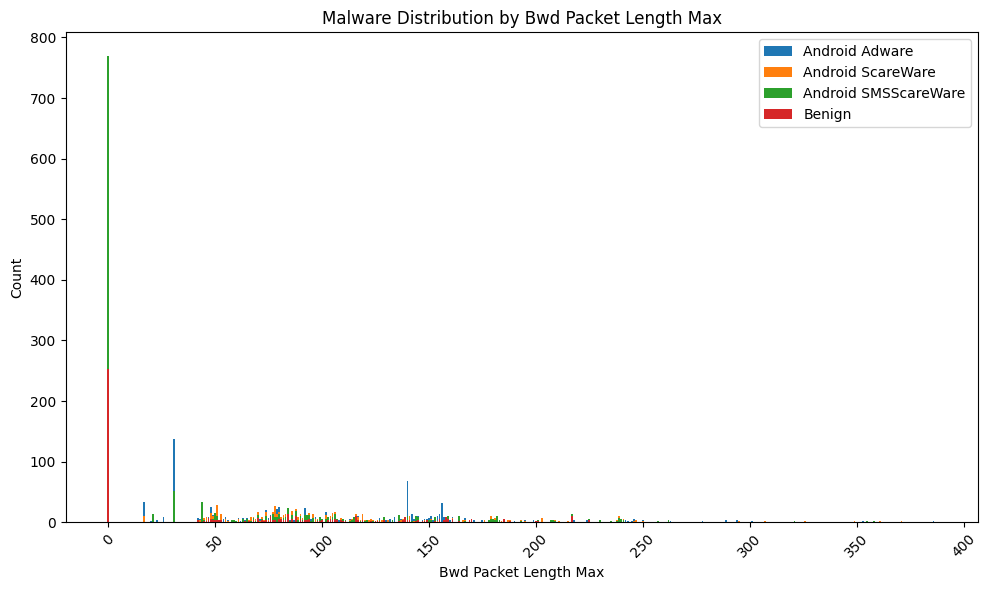

In [15]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Execute the SQL query
query_result = spark.sql("""
    SELECT `am`.`Bwd Packet Length Max`, 
        SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
        SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
        SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
        SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
    FROM android_malware am
    GROUP BY `am`.`Bwd Packet Length Max` 
    ORDER BY `am`.`Bwd Packet Length Max`
""").toPandas()

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(query_result["Bwd Packet Length Max"], query_result["AndroidAdware"], label="Android Adware")
plt.bar(query_result["Bwd Packet Length Max"], query_result["AndroidScareWare"], label="Android ScareWare")
plt.bar(query_result["Bwd Packet Length Max"], query_result["AndroidSMSScareWare"], label="Android SMSScareWare")
plt.bar(query_result["Bwd Packet Length Max"], query_result["Benign"], label="Benign")
plt.xlabel("Bwd Packet Length Max")
plt.ylabel("Count")
plt.title("Malware Distribution by Bwd Packet Length Max")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [16]:
data.createOrReplaceTempView("android_malware")
spark.sql(""" 
SELECT `am`.`Fwd Packet Length Max`, SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
    SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
    SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
    SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
FROM android_malware am
GROUP BY `am`.`Fwd Packet Length Max` 
ORDER BY `am`.`Fwd Packet Length Max` 
""").show()

+---------------------+-------------+----------------+-------------------+------+
|Fwd Packet Length Max|AndroidAdware|AndroidScareWare|AndroidSMSScareWare|Benign|
+---------------------+-------------+----------------+-------------------+------+
|                    0|          623|             590|                610|   207|
|                    1|            0|               0|                  1|     1|
|                    3|            0|               0|                  1|     0|
|                   12|            0|               0|                  0|     2|
|                   18|            9|               0|                  0|     0|
|                   19|            0|               4|                  5|     3|
|                   21|            2|               2|                 16|     0|
|                   22|            7|               1|                  0|     0|
|                   23|           23|               0|                  0|     0|
|               

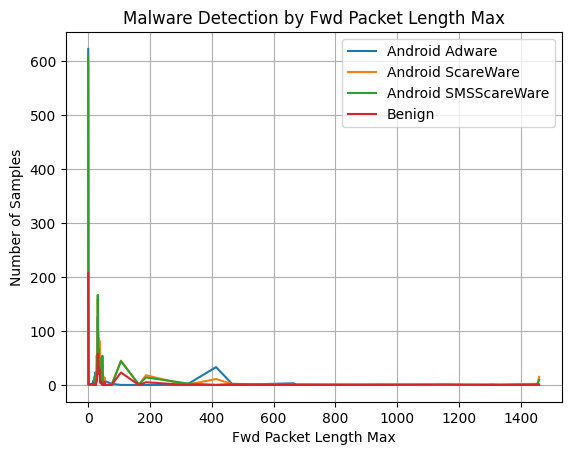

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Execute the SQL query and convert the result to a Pandas DataFrame
query_result = spark.sql("""
    SELECT `am`.`Fwd Packet Length Max`, 
        SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
        SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
        SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
        SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
    FROM android_malware am
    GROUP BY `am`.`Fwd Packet Length Max` 
    ORDER BY `am`.`Fwd Packet Length Max` 
""").toPandas()

# Stop the Spark session
spark.stop()

# Plot the data using matplotlib
plt.plot(query_result["Fwd Packet Length Max"], query_result["AndroidAdware"], label="Android Adware")
plt.plot(query_result["Fwd Packet Length Max"], query_result["AndroidScareWare"], label="Android ScareWare")
plt.plot(query_result["Fwd Packet Length Max"], query_result["AndroidSMSScareWare"], label="Android SMSScareWare")
plt.plot(query_result["Fwd Packet Length Max"], query_result["Benign"], label="Benign")
plt.xlabel("Fwd Packet Length Max")
plt.ylabel("Number of Samples")
plt.title("Malware Detection by Fwd Packet Length Max")
plt.legend()
plt.grid()
plt.show()




In [35]:
data.createOrReplaceTempView("android_malware")
spark.sql(""" 
SELECT `am`.`Fwd IAT Total`,
    SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
    SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
    SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
    SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
FROM android_malware am
GROUP BY `am`.`Fwd IAT Total` 
ORDER BY `am`.`Fwd IAT Total` 
""").show()

+-------------+-------------+----------------+-------------------+------+
|Fwd IAT Total|AndroidAdware|AndroidScareWare|AndroidSMSScareWare|Benign|
+-------------+-------------+----------------+-------------------+------+
|            0|         1775|            1739|               1562|   593|
|       234735|            0|               0|                  0|     1|
|      1007979|            0|               0|                  0|     1|
|      1008001|            0|               0|                  0|     1|
+-------------+-------------+----------------+-------------------+------+



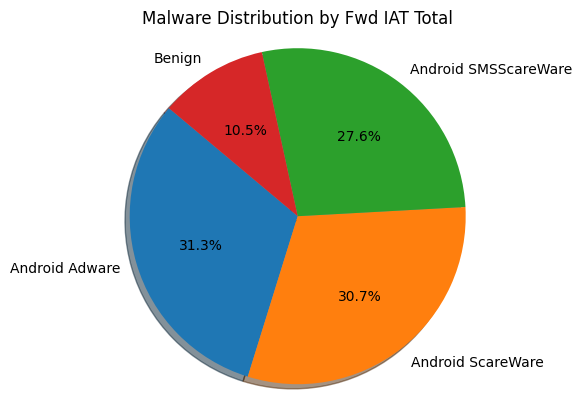

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Execute the SQL query
query_result = spark.sql("""
    SELECT `am`.`Fwd IAT Total`, 
        SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
        SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
        SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
        SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
    FROM android_malware am
    GROUP BY `am`.`Fwd IAT Total` 
    ORDER BY `am`.`Fwd IAT Total` 
""").toPandas()


# Plot the pie chart
labels = ['Android Adware', 'Android ScareWare', 'Android SMSScareWare', 'Benign']
sizes = query_result.iloc[0, 1:]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Malware Distribution by Fwd IAT Total")
plt.show()


In [37]:
data.createOrReplaceTempView("android_malware")
spark.sql(""" 
SELECT `am`.`Flow Duration`,
    SUM(CASE WHEN `am`.`Label` = 0 THEN 1 ELSE 0 END) AS AndroidAdware, 
    SUM(CASE WHEN `am`.`Label` = 1 THEN 1 ELSE 0 END) AS AndroidScareWare,
    SUM(CASE WHEN `am`.`Label` = 2 THEN 1 ELSE 0 END) AS AndroidSMSScareWare,
    SUM(CASE WHEN `am`.`Label` = 3 THEN 1 ELSE 0 END) AS Benign
FROM android_malware am
GROUP BY `am`.`Flow Duration` 
ORDER BY `am`.`Flow Duration` 
""").show()

+-------------+-------------+----------------+-------------------+------+
|Flow Duration|AndroidAdware|AndroidScareWare|AndroidSMSScareWare|Benign|
+-------------+-------------+----------------+-------------------+------+
|            3|            0|               0|                  0|     1|
|            6|            0|               1|                  5|     0|
|            7|            0|               0|                  2|     0|
|            8|            1|               0|                  0|     0|
|            9|            0|               0|                  2|     1|
|           10|            0|               3|                  4|     3|
|           11|            0|               2|                  4|     0|
|           12|            1|               5|                  0|     1|
|           13|            7|               2|                  2|     0|
|           14|            1|               2|                  4|     0|
|           15|            2|         